# 할당된 GPU 확인

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 31 07:52:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score

import seaborn as sns
import cv2
import os
import random
from sklearn.metrics import confusion_matrix, plot_confusion_matrix  # accuracy 지표 계산

In [5]:
# Upload Image Samples from Github
from google.colab import files
uploaded = files.upload()

Saving CNT.zip to CNT.zip


In [6]:
!unzip -qq ./CNT.zip

# Image Samples Pre-processing

In [7]:
CURRENT = './'
CONTENTS = ['0.05', '0.1', '0.2', '0.4']  # CNT Powder Content
CATEGORIES = ['No', 'Sonic']

In [8]:
CNT_IMG = []

for content in CONTENTS:
  for category in CATEGORIES:
      Path = CURRENT + content + '-' + category
      # print(Path)

      for file in os.listdir(Path):
          # Change Image to Numpy array in grayscale
          img_array = cv2.imread(os.path.join(Path, file), cv2.IMREAD_GRAYSCALE)
          # 이미지 파일에, " CNT powder content, sonication 여부" 추가
          CNT_IMG.append([img_array, CONTENTS.index(content), CATEGORIES.index(category), file])

In [9]:
len(CNT_IMG)

322

In [10]:
# Show Image Samples
print(len(CNT_IMG))  # CNT_img, 322

for i, data in enumerate(CNT_IMG):
    img_array = data[0]
    name = data[3]

    plt.rcParams["figure.figsize"] = (50,50)

    plt.subplot(18,18,i+1)
    plt.imshow(img_array, cmap='gray')
    plt.title(name)
    plt.show
    plt.savefig('images before cutting.png')

Output hidden; open in https://colab.research.google.com to view.

#### (a) 4 by 6 로 이미지 자르고, 자른 이미지는 256*256(pixel) 사이즈로 변환하였다.

In [11]:
# Four splits in row and six splits in column -> 24 small samples from one 1080 x 1920 image
n_row = 4
n_col = 6

# Resize image to 256 x 256 pixels
img_size = 256

SMALL_IMG = []

for img_array, content, label, name in CNT_IMG:
    for i in range(n_row):
        for k in range(n_col):
            height = int(img_array.shape[0]/n_row)
            width = int(img_array.shape[1]/n_col)

            small_img = img_array[i*height:(i+1)*height, k*width:(k+1)*width] # Split -> 270 x 320

            small_img = cv2.resize(small_img, (img_size, img_size)) # Resize -> 256 x 256

            # Normalization
            # small_img = small_img

            SMALL_IMG.append([small_img, content, label, name])

In [12]:
len(SMALL_IMG[0][0])

256

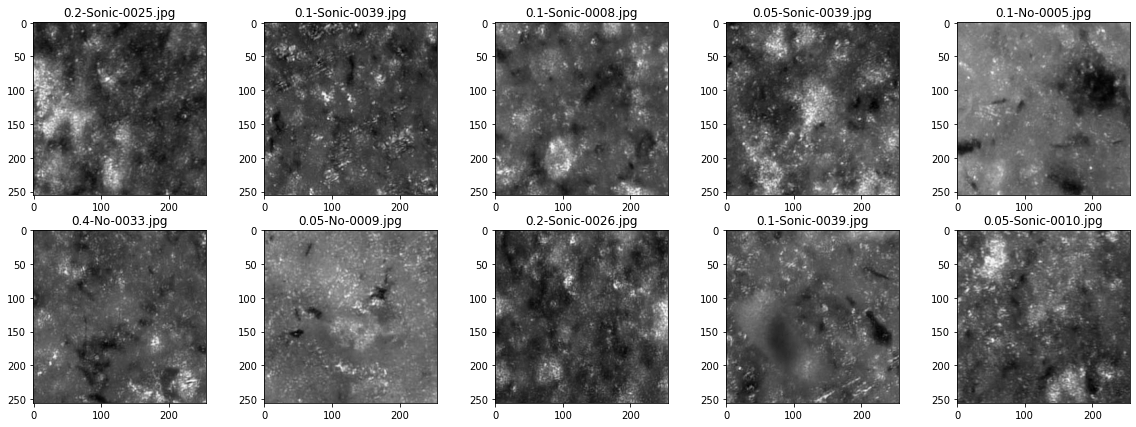

In [13]:
# Show 10 Random Images out of 7728(= 322 x 24) Small Image Samples

RANDOM_IMG = random.sample(SMALL_IMG, 10)

i=1

for img_array, content, label, name in RANDOM_IMG:
    

    plt.rcParams["figure.figsize"] = (20,7)

    plt.subplot(2,5,i)
    plt.imshow(img_array, cmap='gray')
    plt.title(name)
    plt.show

    i+=1

#### (b) Shuffle & Devide by train and test

In [ ]:
# Shuffle images to be trained well
random.shuffle(SMALL_IMG)

In [ ]:
# 6570 Samples -> Train set (대략 85%)
# 1158 Samples -> Test set

Train_Data = SMALL_IMG[:6570]
Test_Data = SMALL_IMG[6570:]

In [ ]:
# 6750 samples
x_train = []
y_train = []  # 첫 번째 출력값, 

for img_array, content, label, name in Train_Data:
    x_train.append(img_array)
    y_train.append(label)

# Change List to Numpy
x_train = np.array(x_train).reshape(6570, img_size, img_size, 1) # (instances, height, width, depth)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

(6570, 256, 256, 1) (6570,)


In [ ]:
# 1158 samples
x_test = []
y_test = []

for img_array, content, label, name in Test_Data:
    x_test.append(img_array)
    y_test.append(label)

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print(x_test.shape, y_test.shape)

(1158, 256, 256, 1) (1158,)


## 1) Sonication-modified

#### (c) 데이터 정규화 및 데이터를 히스토그램 데이터로 바꿈

In [ ]:
# 0~255 normalization
x_train_norm = (x_train - np.min(x_train))/(np.max(x_train)-np.min(x_train))*255
x_histo = np.array( [np.histogram(tmp, range(0,256))[0] for tmp in x_train_norm])
x_histo = np.expand_dims(x_histo, axis=2)

In [ ]:
# 0~255 normalization
x_test_norm = (x_test - np.min(x_test))/(np.max(x_test)-np.min(x_test))*255
x_histo_test = np.array( [np.histogram(tmp, range(0,256))[0] for tmp in x_test_norm])
x_histo_test = np.expand_dims(x_histo_test, axis=2)

In [ ]:
img = cv2.imread('/content/0.05-No/0.05-No-0001.jpg')
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

hist = cv2.calcHist([img], [0], None, [256], [0, 255])
hist_norm = cv2.calcHist([img_norm], [0], None, [256], [0, 255])

cv2_imshow(img)
cv2_imshow(img_norm)

hists = {'Original' : hist, 'normalized':hist_norm }
for i, (k, v) in enumerate(hists.items()):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,i+1)
    plt.title(k)
    plt.plot(v)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with tf.device('/device:GPU:0'):
  tf.model = tf.keras.Sequential()

  tf.model.add(tf.keras.layers.Conv1D(filters=32, input_shape=(255,1), kernel_size=3,
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) # pool_size = (filter_size, stride)

  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
                                    
  tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
  tf.model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_normal', activation='sigmoid'))

  tf.model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  tf.model.summary()

  # Train
  run_results = tf.model.fit(x_histo, y_train, validation_split=0.1, batch_size=32, epochs=100)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 255, 32)           128       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 127, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 127, 64)           6208      
                                                                 
 conv1d_32 (Conv1D)          (None, 127, 64)           12352     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 63, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 63, 128)          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


185/185 [==============================] - 2s 8ms/step - loss: 1.0054 - accuracy: 0.8466 - val_loss: 0.2894 - val_accuracy: 0.8798
Epoch 2/100
185/185 [==============================] - 1s 6ms/step - loss: 0.2579 - accuracy: 0.9031 - val_loss: 0.2172 - val_accuracy: 0.9193
Epoch 3/100
185/185 [==============================] - 1s 6ms/step - loss: 0.2465 - accuracy: 0.9092 - val_loss: 0.2644 - val_accuracy: 0.9178
Epoch 4/100
185/185 [==============================] - 1s 7ms/step - loss: 0.2131 - accuracy: 0.9192 - val_loss: 0.3012 - val_accuracy: 0.9178
Epoch 5/100
185/185 [==============================] - 1s 7ms/step - loss: 0.2156 - accuracy: 0.9202 - val_loss: 0.2118 - val_accuracy: 0.9285
Epoch 6/100
185/185 [==============================] - 1s 6ms/step - loss: 0.2038 - accuracy: 0.9241 - val_loss: 0.2219 - val_accuracy: 0.9178
Epoch 7/100
185/185 [==============================] - 1s 6ms/step - loss: 0.1905 - accuracy: 0.9246 - val_loss: 0.2084 - val_accuracy: 0.9254
Epoch 8/100

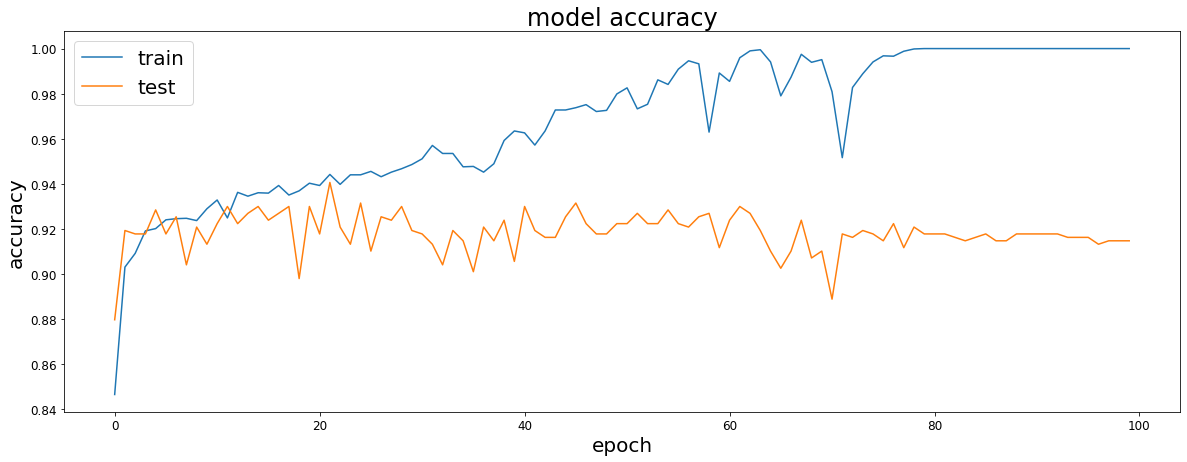

In [ ]:
# summarize history for accuracy
plt.plot(run_results.history['accuracy'])
plt.plot(run_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(run_results)

In [ ]:
# Accuracy
Train_Accuracy = tf.model.evaluate(x_histo, y_train)
Test_Accuracy = tf.model.evaluate(x_histo_test, y_test)

37/37 [==============================] - 0s 3ms/step - loss: 0.8280 - accuracy: 0.9033


In [ ]:
# Predict Test Set
Prediction = []   # 1158개

for pred in tf.model.predict(x_histo_test):
    if pred > 0.5:
        Prediction.append('Sonic')
    else:
        Prediction.append('No')

In [ ]:
Prediction_int = []
Son_count = 0
No_count = 0

for i in Prediction:
  if i == 'No':
    Prediction_int.append(0)
    No_count += 1

  elif i == 'Sonic':
    Prediction_int.append(1)
    Son_count += 1

In [ ]:
# Define CM graph
def show_cm(title,cm):
    mpl.rcParams['font.size']=20
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
   
    # setting font size
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    
    plt.title(f"Confusion Matirx of {title}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks([0.5,1.5], ['No Sonication','Sonication'])
    plt.yticks([0.5,1.5], ['No Sonication','Sonication'])
    plt.show()

In [ ]:
Prediction=tf.model.predict(x_histo_test)

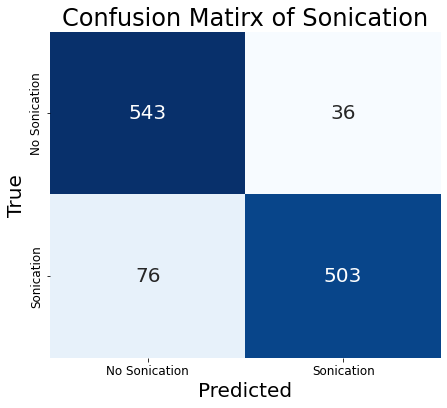

Accuracy: 90.3%


In [ ]:
cm = confusion_matrix(y_test, Prediction_int) 
show_cm('Sonication', cm)  # 대각선이 올바르게 예측한 경우

print(f'Accuracy: {accuracy_score(y_test, Prediction_int)*100:0.1f}%')

## 2) CNT Content

In [ ]:
CURRENT = './'
CONTENTS = ['0.05', '0.1', '0.2', '0.4']  # CNT Powder Content
# CATEGORIES = ['No', 'Sonic']

In [ ]:
CNT_IMG = []

for content in CONTENTS:
      Path = CURRENT + content + '-Sonic'
      print(Path)

      for file in os.listdir(Path):
          # Change Image to Numpy array in grayscale
          img_array = cv2.imread(os.path.join(Path, file), cv2.IMREAD_GRAYSCALE)
          # 이미지 파일에, " CNT powder content, sonication 여부" 추가
          CNT_IMG.append([img_array, CONTENTS.index(content), file])

./0.05-Sonic
./0.1-Sonic
./0.2-Sonic
./0.4-Sonic


In [ ]:
len(CNT_IMG)

160

In [ ]:
# Four splits in row and six splits in column -> 24 small samples from one 1080 x 1920 image
n_row = 4
n_col = 6

# Resize image to 256 x 256 pixels
img_size = 256

SMALL_IMG = []

for img_array, content, name in CNT_IMG:
    for i in range(n_row):
        for k in range(n_col):
            height = int(img_array.shape[0]/n_row)
            width = int(img_array.shape[1]/n_col)

            small_img = img_array[i*height:(i+1)*height, k*width:(k+1)*width] # Split -> 270 x 320

            small_img = cv2.resize(small_img, (img_size, img_size)) # Resize -> 256 x 256

            # Normalization
            # small_img = small_img

            SMALL_IMG.append([small_img, content, name])

In [ ]:
len(SMALL_IMG)

3840

In [ ]:
# Shuffle images to be trained well
random.shuffle(SMALL_IMG)

In [ ]:
# 전체 데이터, 3840 
# 3260 Samples -> Train set (대략 85%)
# 580 Samples -> Test set

Train_Data = SMALL_IMG[:3260]
Test_Data = SMALL_IMG[3260:]

In [ ]:
# 3260 samples
x_train = []
y_train = []  # 두 번째 출력값, CNT powder content 

for img_array, content, name in Train_Data:
    x_train.append(img_array)
    y_train.append(content)

# Change List to Numpy
x_train = np.array(x_train).reshape(3260, img_size, img_size, 1) # (instances, height, width, depth)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

(3260, 256, 256, 1) (3260,)


In [ ]:
# 580 samples
x_test = []
y_test = []

for img_array, content, name in Test_Data:
    x_test.append(img_array)
    y_test.append(content)

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print(x_test.shape, y_test.shape)

(580, 256, 256, 1) (580,)


In [ ]:
def to_one_hot(labels, dimension=4):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

y_train = to_one_hot(y_train) # 훈련 레이블 벡터 변환
y_test = to_one_hot(y_test) # 테스트 레이블 벡터 변환

In [ ]:
# 0~255 normalization
x_train_norm = (x_train - np.min(x_train))/(np.max(x_train)-np.min(x_train))*255
x_histo = np.array( [np.histogram(tmp, range(0,256))[0] for tmp in x_train_norm])
x_histo = np.expand_dims(x_histo, axis=2)

In [ ]:
# 0~255 normalization
x_test_norm = (x_test - np.min(x_test))/(np.max(x_test)-np.min(x_test))*255
x_histo_test = np.array( [np.histogram(tmp, range(0,256))[0] for tmp in x_test_norm])
x_histo_test = np.expand_dims(x_histo_test, axis=2)

In [ ]:
len(x_histo[0])

255

In [ ]:
with tf.device('/device:GPU:0'):
  tf.model = tf.keras.Sequential()

  tf.model.add(tf.keras.layers.Conv1D(filters=32, input_shape=(255,1), kernel_size=3,
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) # pool_size = (filter_size, stride)

  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
                                    
  tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
  tf.model.add(tf.keras.layers.Dense(units=4, kernel_initializer='glorot_normal', activation='softmax'))

  tf.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  tf.model.summary()

  # Train
  run_results = tf.model.fit(x_histo, y_train, validation_split=0.1, batch_size=32, epochs=100)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 255, 32)           128       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 127, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 127, 64)           6208      
                                                                 
 conv1d_27 (Conv1D)          (None, 127, 64)           12352     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 63, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 63, 128)          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


92/92 [==============================] - 2s 9ms/step - loss: 2.0253 - accuracy: 0.7328 - val_loss: 0.4658 - val_accuracy: 0.7975
Epoch 2/100
92/92 [==============================] - 1s 6ms/step - loss: 0.4416 - accuracy: 0.8245 - val_loss: 0.3219 - val_accuracy: 0.8712
Epoch 3/100
92/92 [==============================] - 1s 6ms/step - loss: 0.3704 - accuracy: 0.8538 - val_loss: 0.3207 - val_accuracy: 0.8712
Epoch 4/100
92/92 [==============================] - 1s 6ms/step - loss: 0.3086 - accuracy: 0.8756 - val_loss: 0.3129 - val_accuracy: 0.8988
Epoch 5/100
92/92 [==============================] - 1s 6ms/step - loss: 0.2932 - accuracy: 0.8773 - val_loss: 0.2543 - val_accuracy: 0.9172
Epoch 6/100
92/92 [==============================] - 1s 6ms/step - loss: 0.2871 - accuracy: 0.8793 - val_loss: 0.2841 - val_accuracy: 0.8865
Epoch 7/100
92/92 [==============================] - 1s 6ms/step - loss: 0.2893 - accuracy: 0.8800 - val_loss: 0.2667 - val_accuracy: 0.8896
Epoch 8/100
92/92 [======

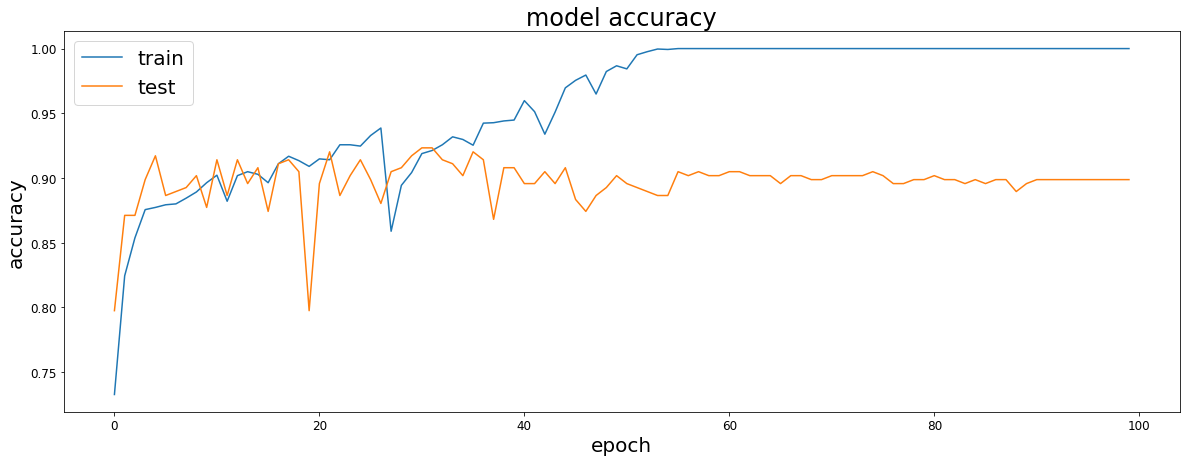

In [ ]:
# summarize history for accuracy
# plt.plot(figuresize())
plt.plot(run_results.history['accuracy'])
plt.plot(run_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Accuracy
Train_Accuracy = tf.model.evaluate(x_histo, y_train)
Test_Accuracy = tf.model.evaluate(x_histo_test, y_test)

19/19 [==============================] - 0s 5ms/step - loss: 1.6182 - accuracy: 0.8862


In [ ]:
# Predict Test Set
Prediction = []  # 580개

for pred in tf.model.predict(x_histo_test):
    for i in range(len(pred)):
        pred_list = list(pred)
        tmp = max(pred)
        label = pred_list.index(tmp)
        Prediction.append(label)

In [ ]:
y_True = []

for row in y_test:
    for i in range(len(row)):
        row_list = list(row)
        tmp = max(row)
        label = row_list.index(tmp)
        y_True.append(label)

In [ ]:
# Define CM graph
def show_cm(title,cm):
    mpl.rcParams['font.size']=20
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
   
    # setting font size
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    
    plt.title(f"Confusion Matirx of {title}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks([0.5,1.5, 2.5, 3.5], ['0.05%','0.1%', '0.2%', '0.4%'])
    plt.yticks([0.5,1.5, 2.5, 3.5], ['0.05%','0.1%', '0.2%', '0.4%'])
    plt.show()

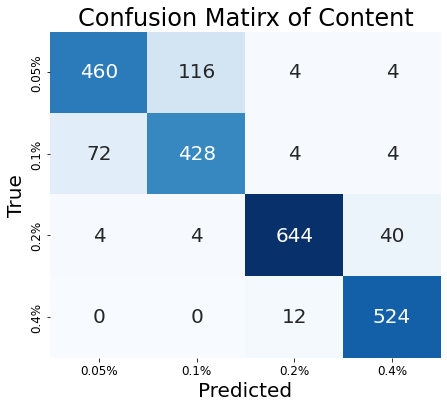

Accuracy: 88.6%


In [ ]:
cm = confusion_matrix(y_True, Prediction)
show_cm('Content', cm)  # 대각선이 올바르게 예측한 경우

print(f'Accuracy: {accuracy_score(y_True,Prediction)*100:0.1f}%')

In [ ]:
# Accuracy
Train_Accuracy = tf.model.evaluate(x_histo, y_train)
Test_Accuracy = tf.model.evaluate(x_histo_test, y_test)

19/19 [==============================] - 0s 4ms/step - loss: 1.6182 - accuracy: 0.8862
